In [1]:
import scipy
import scipy.stats
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import pickle
import pandas as pd
%matplotlib inline

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

Minimum number 1: x=0.090, y=-0.713, f(x, y)=-1.032
Minimum number 2: x=-0.090, y=0.713, f(x, y)=-1.032


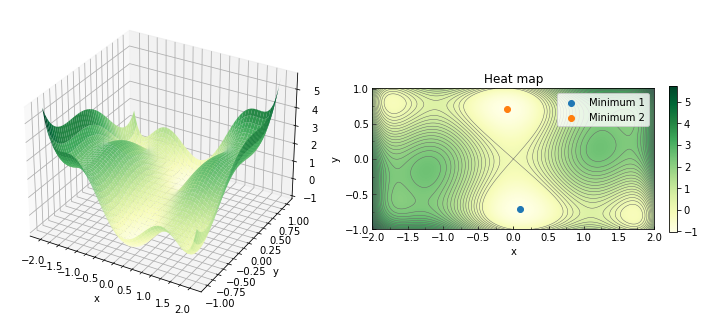

In [8]:
from pylab import meshgrid

def f(variables):
    x, y = variables
    return (4-2.1*pow(x,2)+pow(x,4)/3)*pow(x,2)+x*y+(4*pow(y,2)-4)*pow(y,2)

x = np.linspace(-2, 2, 1000)
y = np.linspace(-1, 1, 1000)

X, Y = meshgrid(x, y)
Z = f((X, Y))
fmin, fmax = np.abs(Z).min(), np.abs(Z).max()

fig = plt.figure(figsize=(12,6))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax0.plot_surface(X, Y, Z, cmap='YlGn')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.xaxis.set_minor_locator(AutoMinorLocator(2))
ax0.yaxis.set_minor_locator(AutoMinorLocator(2))
ax0.tick_params(which='both', direction='in')
ax0.grid(which='major', axis='both', alpha=0.25)
ax0.set_axisbelow(True)

ax1 = fig.add_subplot(1, 2, 2)
c = ax1.pcolormesh(X, Y, Z, cmap='YlGn', shading='auto')
ax1.contour(X, Y, Z, np.linspace(fmin,fmax,40),linewidths=0.5, colors='dimgrey')
ax1.set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax1, fraction=0.024)
ax1.set_title('Heat map')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax1.tick_params(which='both', direction='in')

x0 = [[0, -0.75], [0, 0.75]]
for i, j in enumerate(x0):
    solution = scipy.optimize.minimize(f, j)
    x, y = solution.x
    print("Minimum number %d: x=%1.3f, y=%1.3f, f(x, y)=%1.3f"%(i+1, x, y, f((x,y))))
    ax1.scatter(x, y, marker="o", label='Minimum {}'.format(i+1))
    #ax0.scatter(x, y, f((x,y)), 'ro')
    #ax0.plot( (x,x), (y,y), (-1,5), lw=1, color='red', zorder=0)

plt.legend()
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

[10.5816995   0.59227426 10.15544051 27.94963562]
[-25.14961984   0.60132095  19.27272576 -36.71256441]


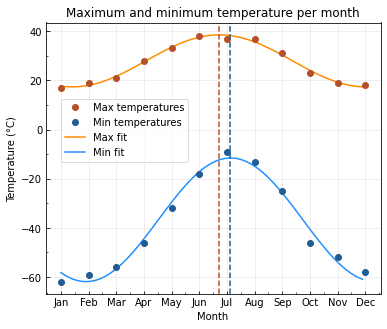

In [3]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x_data = np.arange(1, 13)
max = [17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18]
min = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

fig, ax = plt.subplots(figsize=(6,5))

ax.plot(x_data, max, marker='o', color='#b5512a', label='Max temperatures', linestyle = 'None')
ax.plot(x_data, min, marker='o', color='#235c91', label='Min temperatures', linestyle = 'None')
ax.set_title('Maximum and minimum temperature per month')
ax.set_xlabel('Month')
ax.set_ylabel('Temperature (°C)')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='both', direction='in')
ax.grid(which='major', axis='both', alpha=0.25)
ax.set_axisbelow(True)

def f(x, A, omega, k, const):
    return A * np.sin(omega*x + k) + const

x_space=np.arange(1, 12, 0.1)

popt_max, pcov_max = scipy.optimize.curve_fit(f, x_data, max, p0=[15, 0.8, 10, 30])
ax.plot(x_space, f(x_space, *popt_max), color='darkorange', zorder=0, label='Max fit')
print(popt_max)

popt_min, pcov_min = scipy.optimize.curve_fit(f, x_data, min, p0=[20, 0.4, 20, -40])
ax.plot(x_space, f(x_space, *popt_min), color='dodgerblue', zorder=0, label='Min fit')
print(popt_min)

x_max = x_space[np.argmax(f(x_space, *popt_max))]
x_min = x_space[np.argmax(f(x_space, *popt_min))]
ax.axvline(x_max, color='#b5512a', linestyle='--')
ax.axvline(x_min, color='#235c91', linestyle='--')

ax.legend(framealpha = 0.7, bbox_to_anchor=(0.44,0.47))
_ = plt.xticks(x_data, months)

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [4]:
#!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

with open('data/residuals_261.pkl', 'rb') as infile:
    x = pickle.load(infile)
mydict = dict(x.item())
df_raw = pd.DataFrame(mydict)
df = df_raw[abs(df_raw['residuals'])<2.]

df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


The chi-square is: 460.8792092184535


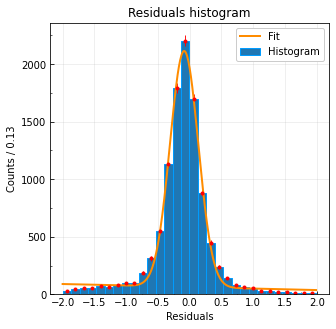

In [5]:
nbins = 30
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

entries, edges, _ = ax.hist(df['residuals'], nbins, edgecolor='#009cff', label='Histogram')
bin_centers = 0.5 * (edges[:-1] + edges[1:])
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.', lw=0.9)
binwidth = edges[1]-edges[0]
ax.set_title('Residuals histogram')
ax.set_xlabel('Residuals')
ax.set_ylabel('Counts / %.2f'%binwidth)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='both', direction='in')
ax.grid(which='major', axis='both', alpha=0.25)
ax.set_axisbelow(True)

def f(x, A, mu, sigma, a, b):
    return A * np.exp(-0.5*((x-mu)/sigma)**2) + a*x + b

popt, pcov = scipy.optimize.curve_fit(f, bin_centers, entries, p0=[3000, 0, -0.5, 1, 5])

x_space=np.arange(-2, 2, 0.01)
ax.plot(x_space, f(x_space, *popt), color='darkorange', label='Fit', lw=2)
ax.legend(framealpha = 1)

chi, pvalue = scipy.stats.chisquare(entries, f(bin_centers, *popt))

print("The chi-square is:", chi)

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [18]:
#!wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt -P data/

df = pd.read_csv("data/munich_temperatures_average_with_bad_data.txt", delimiter=' ', names=('Date', 'Temperature'))
df

,Date,Temperature
0,1995.00274,0.944444
1,1995.00548,-1.611110
2,1995.00821,-3.555560
3,1995.01095,-9.833330
4,1995.01369,-10.222200
...,...,...
6674,2013.27379,7.333330
6675,2013.27652,10.000000
6676,2013.27926,10.555600
6677,2013.28200,8.944440


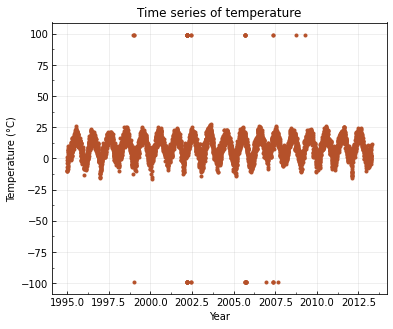

In [24]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(df['Date'], df['Temperature'], marker='.', color='#b5512a', label='Data', linestyle = 'None')
ax.set_title('Time series of temperature')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='both', direction='in')
ax.grid(which='major', axis='both', alpha=0.25)
ax.set_axisbelow(True)
# cambio l'asse x per avere solo gli interi!!